In [1]:
!pip install -q 'git+https://github.com/sarah-keren/multi-taxi'

ERROR: Invalid requirement: "'git+https://github.com/sarah-keren/multi-taxi'"


# Our Problem
The problem that we will focus on today is to make a taxi pick up a passenger, without dropping it at its destination.

![Taxi_domain_show](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/Taxi_domain_show.png)

The only guidance that we will provide to our agent is a **reward function** that prizes the agent for picking up the passenger and that penalizes the agent for taking too many steps to reach the goal.

In particular, the reward function is defined as follows:
- +100 points for a successful drop-off
- -1 point for every bad pick-up
- -2 points for hitting an obstacle (e.g. a wall)
- -1 for every step taken

In [31]:
from multi_taxi import Event

customized_reward = {
    Event.PICKUP: 100,
    Event.BAD_PICKUP: -5,
    Event.HIT_OBSTACLE: -2,
    Event.STEP: -1
}

# Our Tools

## Monte Carlo Simulation

In [32]:
import numpy as np
from multi_taxi.world.maps import DEFAULT_MAP, BIG_MAP
from IPython.display import clear_output
import matplotlib.pyplot as plt
from multi_taxi import multi_taxi_v0


In [33]:
def new_environment_creator(taxi_pos, passenger_pos, 
                            num_taxis=1,num_passengers=1, 
                            pickup_only=True, can_see_other_taxi_info=False, 
                            domain_map=DEFAULT_MAP,reward_table=customized_reward):
    """
    A helper function to setup a new environment with predefined taxi and passenger locations
    """
    new_env = multi_taxi_v0.env(num_taxis=num_taxis, num_passengers=num_passengers, pickup_only=pickup_only, domain_map=domain_map,
                                can_see_other_taxi_info=can_see_other_taxi_info,reward_table=reward_table, 
                                render_mode='human', allow_arrived_passengers_on_reset=False)
    new_env.reset()

    state = new_env.state()
    state.taxis[0].location = taxi_pos
    state.passengers[0].location = passenger_pos
    new_env.unwrapped.set_state(state)

    return new_env

In [34]:
taxi_position = (0,0)
passenger_position = (3,3)
env = new_environment_creator(taxi_position, passenger_position)

done = False
step = 0
gamma = 0.9
accumulated_reward = 0
while not done:
    action = np.random.randint(5)
    env.step(action)
    obs, reward, done, trunc, info = env.last()
    clear_output(wait=True)
    accumulated_reward += reward*(gamma**step)
    print(f"step {step}: accumulated reward {accumulated_reward}")
    env.render()
    step += 1

step 1255: accumulated reward -21.40420320579739
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 1256, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



![monte_carlo_control_schema](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/Monte_Carlo_Control_complete.png)

# Monte Carlo Control Algorithm
![monte_carlo_control_algorithm](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/monte_carlo_control_algorithm.png)

In [35]:
from collections import defaultdict
import numpy as np
import json
from copy import deepcopy
import time
from tqdm import trange

class MonteCarloControl:
    def __init__(self, state, gamma:float = 0.9, train_episode_number:int=1_000,
                 max_steps_per_episode:int = 1_000) -> None:
        '''
        :args state: environment with the initial state
        :args gamma: discount factor
        :args train_episode_number: number of episodes used to train the agent (it is only used in the function train)
        :args max_steps_per_episode: maximum number of steps 
        '''
        self.state = state
        self.Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.N = defaultdict(lambda: defaultdict(lambda: 0))
        self.visited = set()
        self.episode_number = 0
        self.gamma = gamma
        self.train_episode_number = train_episode_number
        self.max_steps_per_episode = max_steps_per_episode
    
    def save(self, filename):
        state = self.state.unwrapped.state()
        taxi_position = state.taxis[0].location
        passenger_position = state.passengers[0].location
        json_data = {
            'Q': self.Q,
            'N': self.N,
            'episode_number': self.episode_number,
            'gamma': self.gamma,
            'max_episode_number': self.max_episode_number,
            'max_steps_per_episode': self.max_steps_per_episode,
            'taxi_position': taxi_position,
            'passenger_position': passenger_position
        }
        with open(filename, 'w') as f:
            json.dump(json_data, f)


    def load(self, filename):
        with open(filename, 'r') as f:
            json_data = json.load(f)
        self.Q = json_data['Q']
        self.N = json_data['N']
        self.episode_number = json_data['episode_number']
        self.gamma = json_data['gamma']
        self.max_episode_number = json_data['max_episode_number']
        self.max_steps_per_episode = json_data['max_steps_per_episode']
        taxi_position = json_data['taxi_position']
        passenger_position = json_data['passenger_position']
        state = self.env.unwrapped.state()
        state.taxis[0].location = taxi_position
        state.passengers[0].location = passenger_position
        self.state.unwrapped.set_state(state)

    def policy(self, state, epsilon = None, warn=False):
        if epsilon is None:
            epsilon = 1/np.sqrt(self.episode_number + 1)
        else:
            epsilon = epsilon
        number_of_actions = len(self.state.unwrapped.get_action_map('taxi_0').values())
        if np.random.random() < epsilon:
            action = np.random.choice(number_of_actions)
        else:
            # convert state to use as key in Q
            state = state.unwrapped.state().taxis[0].location
            if state in self.visited:
                action = max(self.Q[state], key=self.Q[state].get)
            else:
                if warn:
                    print('The action was not in Q! Chose randomly')
                action = np.random.choice(number_of_actions)
        return action
    
    def update(self, episode):
        G = 0
        for i, (state, action, reward) in enumerate(reversed(episode)):
            G = (self.gamma**i) * G + reward
            # convert state to use as key in Q
            state = state.unwrapped.state().taxis[0].location
            self.visited.add(state)
            self.N[state][action] += 1
            self.Q[state][action] += (G - self.Q[state][action]) / self.N[state][action]
    
    def train(self):
        # Train the policy without taking steps in the actual experience
        for _ in trange(self.train_episode_number):
            self.episode_number += 1
            current_episode_state = deepcopy(self.state)
            episode = []
            for _ in range(self.max_steps_per_episode):

                action = self.policy(current_episode_state)
                old_state = current_episode_state
                current_episode_state.step(action)
                obs, reward, done, trunc, info = current_episode_state.last()
                episode.append((old_state, action, reward))
                if done:
                    break
            self.update(episode)
    
    def run(self, starting_state=None, max_number_of_steps=100):
        # Run the policy without improving it
        if starting_state is not None:
            current_state = deepcopy(starting_state)
        else:
            current_state = deepcopy(self.state)
        for i in range(1,max_number_of_steps+1):
            action = self.policy(current_state, epsilon=0)
            current_state.step(action)
            obs, reward, done, trunc, info = current_state.last()
            clear_output(wait=True)
            print(i)
            current_state.unwrapped.render()
            if done:
                break
    
    def step_and_update(self, number_of_simulated_episodes=100, max_number_of_steps=150):
        # Train the policy for max_number_of_simulated_episodes and then take a step
        current_state = deepcopy(self.state)
        steps = 0
        for i in range(1,max_number_of_steps+1):
            steps = i
            # TRAINING STEP
            self.episode_number = 0
            for _ in range(number_of_simulated_episodes):
                # train on the current state
                self.episode_number += 1
                current_training_state = deepcopy(current_state)
                episode = []
                for _ in range(self.max_steps_per_episode):

                    action = self.policy(current_training_state)
                    old_state = deepcopy(current_training_state)
                    current_training_state.step(action)
                    obs, reward, done, trunc, info = current_training_state.last()
                    episode.append((old_state, action, reward))
                    if done:
                        break
                self.update(episode)
            # ACTUAL STEP
            action = self.policy(current_state)
            old_state = current_state.unwrapped.state().taxis[0].location
            current_state.step(action)
            obs, reward, done, trunc, info = current_state.last()
            time.sleep(1)
            clear_output(wait=True)
            print(i)
#             print(f"action executed:{action}")
#             print(f"q values: {self.Q[old_state].items()}")
            current_state.unwrapped.render()
            if done:
                break
        return steps

In [36]:
env = new_environment_creator(taxi_pos=(0,0), passenger_pos=(3,3))
monte_carlo_control = MonteCarloControl(env, gamma=0.99, max_steps_per_episode=1_000)

In [7]:
# monte_carlo_control.train()
# monte_carlo_control.run()

100
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : :P: : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (4, 1), Engine: ON, Collided: False, Step: 100, ALIVE
Passenger0-YELLOW: Location: (3, 3), Destination: (-1, -1)
Env done: False



In [37]:
monte_carlo_control.step_and_update(number_of_simulated_episodes=10)

7
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 7, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



7

# Monte Carlo Tree Search

# The 4 steps of MCTS

MCTS consists of four main steps: selection, expansion, simulation, and backpropagation.

1. **Selection.** Select a leaf node using **tree policy**.
2. **Expansion.** **Add children** to the selected leaf using unexplored actions
3. **Rollout.** From the selected child **simulate** an **episode** using the **rollout policy**
4. **Backpropagation**. **Update** the average **value** of the nodes starting **from** the selected **child** up **to** the **root** using the results of the rollout episode
    - ATTENTION: No values are saved for the states and actions visited by the rollout policy beyond the tree! 

![mcts_4_steps](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/mcts_4_steps.png)

MCTS **repeats** this cycle until **no time** is left (starting at the root node each time). **Finally**, MCTS **chooses** the **action** to make from the root node.

# Rollout policy and Tree policy

* **Rollout policy**: a simple policy generating actions in the **simulated trajectories**

* **Tree policy**: policy for traversing the tree and **selecting** a **child node** that is most promising according to a selection policy, which balances exploration and exploitation of the search space. 
    * examples : $\epsilon$-greedy, UCT
    
    * $UCT = \underbrace{Q}_{exploitation} + \underbrace{C \sqrt{\frac{\log(N)}{n}}}_{exploration}$
   
   Where: 
   - $Q$ is the average Q-value of the considered state-action pair
   - $C$ is a constant that balances exploration and exploitation
   - $N$ is the total number of times that the current node has been visited
   - $n$ is the number of times that the considered child node has been visited


In [7]:
class MonteCarloTreeSearchNode():
    def __init__(self, state, n_simulations=100, parent=None, parent_action=None, gamma = 0.9, new_env_creator=new_environment_creator):
        # environment holding the current state
        self.state = state
        # None for the root node, otherwise it is equal to the node it is derived from.
        self.parent = parent
        # None for the root node, otherwise it is equal to the action which its parent carried out.
        self.parent_action = parent_action 
        # Contains all possible actions from the current node.
        self.children = []
        # Number of times current node is visited.
        self.number_of_visits = 0 
        self.average_reward = 0
        # Set of all of the possible actions
        self._untried_actions = self.get_legal_actions()
        self.terminal_state = False
        self.new_env_creator = new_env_creator
        self.gamma = gamma
        # Number of loops with the four stages
        self.n_simulations = n_simulations
    
    def best_action(self):
        """
        Execute the four stages to find the best action from the current state.
        """
        for _ in range(self.n_simulations):
            node = self._tree_policy()
            reward = node.rollout()
            node.backpropagate(reward)

        return self.best_child(c_param=0.)

    def _tree_policy(self):
        """
        Select node from which we run the rollout.
        """
        current_node = self
        while not current_node.is_terminal_node():
            # if there is an action that has not been tried yet, return the child node corresponding to this action
            if not current_node.is_fully_expanded():
                return current_node.expand()
            # else select the best child node
            else:
                current_node = current_node.best_child()
        return current_node

    def is_terminal_node(self):
        """
        This is used to check if the current node is terminal or not. 
        Terminal node is reached when the game is over.
        """
        return self.terminal_state
    
    def is_fully_expanded(self):
        """
        All the actions are poped out of _untried_actions one by one. 
        When it becomes empty, that is when the size is zero, it is fully expanded.
        """
        return len(self._untried_actions) == 0

    def expand(self):
        """
        Select an action that has not been tried yet and return the corresponding child node.
        """
        # select an action that has not been tried yet
        action = self._untried_actions.pop()
        
        state = self.state.unwrapped.state()
        taxi_pos = state.taxis[0].location
        passenger_pos = state.passengers[0].location
        new_env = self.new_env_creator(taxi_pos,passenger_pos)
        new_env.step(action)
        obs, reward, done, trunc, info = new_env.last()
        child_node = MonteCarloTreeSearchNode(state = new_env, n_simulations=self.n_simulations,
                                            parent=self, parent_action=action, new_env_creator= self.new_env_creator,   gamma=self.gamma)
        child_node.terminal_state = done
        
        self.children.append(child_node)
        return child_node
    
    def best_child(self, c_param=0.8):
        """
        Once fully expanded, this function selects the best child out of 
        the children array. The first term in the formula corresponds to 
        exploitation and the second term corresponds to exploration.
        """
        choices_weights = [self.uct(child, c_param) for child in self.children] 
        return self.children[np.argmax(choices_weights)]
    
    def uct(self, child, c_param):
        if self.number_of_visits == 0 or child.number_of_visits == 0:
            return float("inf")
        return child.average_reward + \
                c_param*np.sqrt(np.log(self.number_of_visits)/child.number_of_visits)
    
    def rollout(self):
        """
        From the current state, entire game is simulated till there is an 
        outcome for the game. This outcome of the game is returned.
        """
        
        state = self.state.env.unwrapped.state()
        taxi_pos = state.taxis[0].location
        passenger_pos = state.passengers[0].location
        
        current_rollout_state = self.new_env_creator(taxi_pos,passenger_pos)

        _reward = 0
        step = 0
        done = False
        while not done:
            possible_moves = self.get_legal_actions()

            action = self.rollout_policy(possible_moves)
            current_rollout_state.step(action)
            obs, reward, done, trunc, info = current_rollout_state.last()
            _reward += reward *(self.gamma ** step)
            step += 1
        return _reward
    
    def get_legal_actions(self): 
        ''' 
        Returns a list of all of the possible actions from current state.
        '''
        return list(self.state.unwrapped.get_action_map('taxi_0').values())
    
    def rollout_policy(self, possible_moves):
        """
        Randomly selects a move out of possible moves.
        """
        return possible_moves[np.random.randint(len(possible_moves))]

    def backpropagate(self, reward):
        """
        In this step all the statistics for the nodes are updated. 
        Untill the parent node is reached, the number of visits for 
        each node is incremented by 1.
        """
        self.number_of_visits += 1.
        self.average_reward = self.average_reward + (1/self.number_of_visits)*(reward-self.average_reward)
        if self.parent:
            self.parent.backpropagate(reward)  

In [8]:
env = new_environment_creator(taxi_pos=(0,0), passenger_pos=(3,3))
root = MonteCarloTreeSearchNode(state = env, n_simulations = 20, gamma=0.78, new_env_creator = new_environment_creator)
root.state.unwrapped.render()
selected_node = root.best_action()
step = 1
while not selected_node.terminal_state:
    selected_node = selected_node.best_action()
    clear_output(wait=True)
    print(step)
    selected_node.state.env.render()
    step += 1

15
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



# Rapid Action Value (RAVE)
- It created the first program to achieve dan (master) level in Go. [[Gelly, Silver 2011]](https://www.sciencedirect.com/science/article/pii/S000437021100052X)
- **MCTS** requires a **lot of simulations** to sample several pairs of state and action
- To **speed up** this estimate we can introduce a **bias**
- We will **update** the pair $\langle s, a \rangle$ **with** the **reward** obtained **using** $a$ **from** any state in the **subtree** of $s$ (AMAF heuristic)
![rave](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/rave.png)

- In order to balance these two estimates we will use the following formula
$$
\tilde{Q}(s,a) = (1-\beta(s,a))*Q(s,a) + \beta(s,a)*RAVE(s,a)
$$
Where:
- $\tilde{Q}(s,a)$ is the final value attributed to the pair $\langle s, a \rangle$
- $\beta(s,a)$ is a parameter which dynamically balances these two estimates
- $Q(s,a)$ is the average Q-value of $\langle s, a \rangle$
- $RAVE(s,a)$ is the RAVE value of $\langle s, a \rangle$

$$\beta(s,a) = \sqrt{\frac{k}{3N(s,a)+k}}$$
Where:
- $N(s)$ is the number of times that we visited the current node
- $k$ is an hyperparameter that sets the number of simulation at which $Q$ and $RAVE$ are given the same weight

![beta](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/beta.png)

In [9]:
class RAVEMonteCarloTreeSearchNode(MonteCarloTreeSearchNode):
    '''Introduce RAVE optimization to MCTS'''
    def __init__(self, state, n_simulations=100, parent=None, parent_action=None, k=3, gamma=0.78, new_env_creator=new_environment_creator):
        super().__init__(state, n_simulations, parent,parent_action, gamma=gamma, new_env_creator=new_env_creator)
        self.average_reward_rave = 0
        self.number_of_visits_rave = 0
        self.k = k
    
    def best_action(self):
        """
        Execute the four stages to find the best action from the current state.
        """
        for _ in range(self.n_simulations):
          node = self._tree_policy()
          reward, taken_actions = node.rollout()
          node.backpropagate(reward, taken_actions)

        return self.best_child(c_param=0.)
    
    def _tree_policy(self):
      """
      Selects node to run rollout.
      """
      current_node = self
      while not current_node.is_terminal_node():

          if current_node._is_leaf():
              # Differently from what we did in Monte Carlo Tree Search, even if we do not select
              # a certain child from the current node, we still need to create it so that 
              # we will be able to update its rave value in the backpropagation step.
              current_node._create_all_children()
              return current_node.best_child()
          
          current_node = current_node.best_child()
      return current_node

    def _is_leaf(self):
        return len(self.children) == 0

    def _create_all_children(self):

        for action in self._untried_actions:

            state = self.state.unwrapped.state()
            taxi_pos = state.taxis[0].location
            passenger_pos = state.passengers[0].location
            new_env = self.new_env_creator(taxi_pos,passenger_pos)
            new_env.step(action)
            obs, reward, done, trunc, info = new_env.last()
            child_node = RAVEMonteCarloTreeSearchNode(state = new_env, n_simulations=self.n_simulations,
                            parent=self, parent_action=action, new_env_creator=self.new_env_creator,
                            k=self.k, gamma=self.gamma)
            child_node.terminal_state = done

            self.children.append(child_node)

    def best_child(self, c_param=0.8):
        choices_weights = [self.mc_rave(child, c_param) for child in self.children] 
        return self.children[np.argmax(choices_weights)]

    def mc_rave(self, child, c_param):
        uct =  float('inf') if (child.number_of_visits == 0 or self.number_of_visits == 0) else child.average_reward + \
        c_param*np.sqrt( \
          np.log(self.number_of_visits)/ child.number_of_visits \
        )
        beta = np.sqrt(self.k / (3 * self.number_of_visits + self.k))
        monte_carlo_value = float('inf') if uct == float('inf') \
                  else (1-beta)*uct
        rave_value = float('inf') if child.number_of_visits_rave == 0 \
                  else beta*child.average_reward_rave
        return monte_carlo_value + rave_value

    def rollout(self):
        state = self.state.env.unwrapped.state()
        taxi_pos = state.taxis[0].location
        passenger_pos = state.passengers[0].location

        current_rollout_state = self.new_env_creator(taxi_pos,passenger_pos)

        _reward = 0
        step = 0
        done = False
        taken_actions = []
        while not done:
            possible_moves = self.get_legal_actions()

            action = self.rollout_policy(possible_moves)
            current_rollout_state.step(action)
            obs, reward, done, trunc, info = current_rollout_state.last()
            _reward += reward*(self.gamma**step)
            # DIFFERENCE FROM MONTE CARLO TREE SEARCH: we need to keep track of the actions taken
            taken_actions.append(action)
            ##############################
            step += 1
        return _reward, taken_actions

    def backpropagate(self, reward, taken_actions):
        self.number_of_visits += 1
        self.average_reward = self.average_reward + (1/self.number_of_visits)*(reward-self.average_reward)

        # DIFFERENCE FROM MONTE CARLO TREE SEARCH: we need to update the rave estimates of the children
        for action in set(taken_actions):
            for child in self.children:
                if child.parent_action == action:
                    child.update_rave_estimate(reward)
        ##############################
        
        if self.parent is not None:
            self.parent.backpropagate(reward, taken_actions)
    
    def update_rave_estimate(self, reward):
        self.number_of_visits_rave += 1
        self.average_reward_rave = self.average_reward_rave + (1/self.number_of_visits_rave)*(reward-self.average_reward_rave)


In [10]:
env = new_environment_creator(taxi_pos=(0,0),passenger_pos=(3,3))
root = RAVEMonteCarloTreeSearchNode(state = env, n_simulations = 20, k=1, gamma=0.78)
root.state.unwrapped.render()
selected_node = root.best_action()
step = 1
while not selected_node.terminal_state:
    selected_node = selected_node.best_action()
    clear_output(wait=True)
    print(step)
    selected_node.state.env.render()
    step += 1

12
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



In [7]:
def evaluate_policy(algorithm, simulations):
    if not algorithm in ["Monte Carlo Control", "Monte Carlo Tree Search", "RAVE"]:
        raise ValueError("Algorithm must be one among: Monte Carlo Control, Monte Carlo Tree Search and RAVE")
    
    env = new_environment_creator(taxi_pos=(0,0), passenger_pos=(3,3))

    if algorithm == "Monte Carlo Control":
        # Monte Carlo Control
        monte_carlo_control = MonteCarloControl(env, gamma=0.99, max_steps_per_episode=1_000)
        step = monte_carlo_control.step_and_update(number_of_simulated_episodes=10)
        return step

    elif (algorithm=="Monte Carlo Tree Search"):
        # Monte Carlo Tree Search
        root = MonteCarloTreeSearchNode(state = env, n_simulations=simulations, gamma=0.78, new_env_creator=new_environment_creator)
        root.state.unwrapped.render()
        selected_node = root.best_action()
        step = 1
        while not selected_node.terminal_state:
            selected_node = selected_node.best_action()
            clear_output(wait=True)
            print(step)
            selected_node.state.env.render()
            step += 1
        return step
    
    elif (algorithm =="RAVE"):
        # RAVE
        root = RAVEMonteCarloTreeSearchNode(state = env, n_simulations = simulations, k=1, gamma=0.78, new_env_creator=new_environment_creator)
        root.state.unwrapped.render()
        selected_node = root.best_action()
        step = 1
        while not selected_node.terminal_state:
            selected_node = selected_node.best_action()
            clear_output(wait=True)
            print(step)
            selected_node.state.env.render()
            step += 1
        return step

In [15]:
import matplotlib.pyplot as plt

def plot_steps_per_simulations(algorithms, simulations_per_step, number_of_experiments):

    data_to_plot = [[] for _ in range(len(algorithms))]

    
    for sim in simulations_per_step:
        for i, algorithm in enumerate(algorithms): 
            print(f"{algorithm} for {sim} simulations")
            steps=0
            for _ in range(number_of_experiments):
                steps += evaluate_policy(algorithm ,sim)
            data_to_plot[i].append(steps/number_of_experiments)

    print("Experiments' results:")
    print(data_to_plot)

    _, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.set_title(f"Performance")
    for i, algorithm in enumerate(algorithms): 
        ax.plot(simulations_per_step, data_to_plot[i], '-o', label=algorithm)
    ax.set_xlabel("Simulations per step")
    ax.set_ylabel("Steps")
    ax.grid()
    ax.legend()
    plt.savefig("performance.png")
    plt.show()

    return data_to_plot

8
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True

Experiments' results:
[[10.8, 10.9, 10.4, 12.9], [20.3, 12.4, 11.5, 11.4], [23.3, 12.0, 12.3, 11.8]]


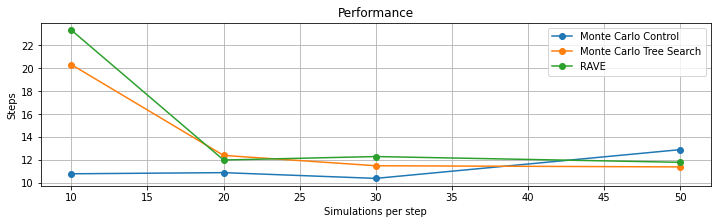

In [16]:
# results = plot_steps_per_simulations(["Monte Carlo Control", "Monte Carlo Tree Search", "RAVE"],[10,20,30,50],10)

In [17]:
# save results
# import pickle

# with open('results.pickle', 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

![performance](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/performance.png)

# TODO 1
1. Define a new function which calls new_environment_creator with passenger_location = (6,7) with the DEFAULT_MAP
2. Create a new environment with this new function
3. Initialize MCTS node by setting as environment this environment, by setting new_env_creator to be the function created in step 1. and by setting n_simulations to be 20
4. Run MCTS
5. Repeat step 4-5 with n_simulations to be 100
6. Repeat the previous steps for RAVE

# TODO 2
1. Define a new function which calls new_environment_creator with taxi position = (2,0) and with domain_map=BIG_MAP
2. Create a new environment with this new function
3. Initialize MCTS node by setting as environment this environment, by setting new_env_creator to be the function created in step 1. and by setting n_simulations to be 20
4. Run MCTS
5. Repeat step 4-5 with n_simulations to be 100
6. Repeat the previous steps for RAVE

# TODO 3 (Optional)
1. Define a new function which calls new_environment_creator with taxi position = (2,0) with passenger_location = (6,7) and with domain_map=BIG_MAP
2. Create a new environment with this new function
3. Initialize MCTS node by setting as environment this environment, by setting new_env_creator to be the function created in step 1. and by setting n_simulations to be 20
4. Run MCTS
5. Repeat step 4-5 with n_simulations to be 100
6. Repeat the previous steps for RAVE